<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: k-mer Representation with Frequency Analysis
   - Break the DNA sequence into k-mers (subsequences of length k).
   - Perform frequency analysis to create a feature vector based on the occurrence of each k-mer.
   - Use this feature vector as input to the model.

3. **Pros**:
   - Captures local context within each k-mer.
   - Simplifies the input representation by reducing it to frequency counts.

4. **Cons**:
   - Loses positional information beyond the k-mer length.
   - Treating it as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model ignores the order of k-mers.
   - Depending on the k value chosen, k-mer representation can lead to high-dimensional features.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier

# Metric and utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import zscore

# Warning
import warnings
warnings.filterwarnings("ignore")

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [3]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing
Instead of taking each base as an individual feature, we transform DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tranformed into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: **3, 4, 5, and 6**.

In [4]:
# Utils: to count kmer occurence in DNA sequence and compute frequence

def kmer_count(sequence, k=3, step=1):
    kmers_count = {}
    s = 0
    for i in range(0, len(sequence) - k + 1, step):
        kmer = sequence[i:i + k]
        s += 1
        if kmer in kmers_count:
            kmers_count[kmer] += 1
        else:
            kmers_count[kmer] = 1
    for key, value in kmers_count.items():
        kmers_count[key] = value / s

    return kmers_count

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [4]:
k = 3
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [5]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_3 = pd.DataFrame(feature_values, columns=feature_names)
X_3.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.028758,0.018736,0.028322,0.024401,0.013508,0.008715,0.005664,0.018301,0.029630,0.012636,...,0.010022,0.025272,0.026144,0.013072,0.014815,0.016993,0.018301,0.024837,0.026144,0.043573
1,0.042148,0.015636,0.020394,0.040789,0.014956,0.004759,0.005438,0.015636,0.031271,0.007478,...,0.010197,0.035350,0.019714,0.008158,0.010877,0.010197,0.031271,0.036030,0.012916,0.062542
2,0.030108,0.019959,0.025034,0.021313,0.013532,0.008119,0.007442,0.016915,0.024357,0.011502,...,0.010487,0.032476,0.019959,0.015223,0.017591,0.022327,0.016238,0.029770,0.026725,0.046008
3,0.037222,0.016795,0.019065,0.029051,0.018157,0.009532,0.005447,0.011802,0.022696,0.006809,...,0.005901,0.024966,0.019065,0.012710,0.011348,0.020881,0.031321,0.027236,0.019519,0.059464
4,0.034068,0.019539,0.033567,0.018537,0.022044,0.011523,0.009519,0.012024,0.036072,0.014028,...,0.009018,0.028056,0.017535,0.006012,0.013026,0.019539,0.018537,0.019539,0.020541,0.049098


In [6]:
y = dataset['class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [7]:
# Split data
X_3_train, X_3_test, y_train, y_test = train_test_split(X_3, y, train_size=0.8, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_3_train.shape)
print("X_test:", X_3_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (304, 64)
X_test: (76, 64)
y_train: (304,)
y_test: (76,)


* Let tune our differents model

In [8]:
# Define the hyperparameter grids
param_grids = {
    "Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Gaussian Process": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]},
    "Random Forest": {'max_depth': [3, 5, 7], 'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3]},
    "Neural Net": {'alpha': [0.0001, 0.001, 0.01]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Naive Bayes": {},
    "SVM Linear": {'C': [0.1, 1, 10]},
    "SVM RBF": {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
    "MultinomialNB": {'alpha': [0.01, 0.001, 0.1, 1, 10]},
    "XGBClassifier": {'n_estimators':[2, 3, 5, 10, 20, 100, 200], 'max_depth':[2, 3, 5, 7]}
}

# Models
names = ["Nearest Neighbors", "XGBClassifier", "Gaussian Process", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "SVM Linear", "SVM RBF", "MultinomialNB"]
classifiers = [
    KNeighborsClassifier(),
    XGBClassifier(objective='binary:logistic'),
    GaussianProcessClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=10000, early_stopping=False),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    MultinomialNB(),
]
models = zip(names, classifiers)

In [9]:
results = []
names   = []
best_parameters = []

for name, model in models:
    print(f"Processing {name}...")
    param_grid = param_grids[name]
    kfold = KFold(n_splits=10, random_state=42, shuffle=True) #stratifiedkfold???
    
    # Perform grid search & Get the best model
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_3_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_parameters.append((name, best_params))
    print('Best params found: ', best_params)
    
    # Cross-validation results
    cv_results = cross_val_score(best_model, X_3_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "[Train] - '{}' - acc: {} ±({})".format(name, cv_results.mean(), cv_results.std())
    print("{}\n{}\n{}".format('-'*80, msg, '-'*80))
    
    # Fit the best model
    best_model.fit(X_3_train, y_train)
    
    # Make predictions and print test results
    predictions = best_model.predict(X_3_test)
    print("[Test]  - '{}' - acc : {}".format(name, accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions), end="\n")

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - acc: 0.7836559139784947 ±(0.0771632562293768)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - acc : 0.8552631578947368
              precision    recall  f1-score   support

           0       0.96      0.69      0.80        32
           1       0.81      0.98      0.89        44

    accuracy                           0.86        76
   macro avg       0.88      0.83      0.84        76
weighted avg       0.87      0.86      0.85        76

Processing XGBClassifier...
Best params found:  {'max_depth': 5, 'n_estimators': 200}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - acc: 0.8523655913978496 ±(0.050514865609930286)
--------------------------------------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [10]:
k = 4
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [11]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_4 = pd.DataFrame(feature_values, columns=feature_names)
X_4.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.008282,0.008718,0.006975,0.004795,0.006103,0.003487,0.001744,0.007411,0.011334,0.005667,...,0.003923,0.009590,0.007411,0.004795,0.006103,0.007847,0.006975,0.008718,0.010026,0.017873
1,0.019728,0.004762,0.002721,0.014966,0.004082,0.002041,0.002041,0.007483,0.010884,0.002041,...,0.003401,0.017007,0.005442,0.002721,0.002041,0.002721,0.010884,0.019048,0.006803,0.025850
2,0.007783,0.007783,0.010152,0.004399,0.007107,0.003723,0.002707,0.006430,0.010829,0.005076,...,0.004061,0.013875,0.008122,0.004399,0.005076,0.009137,0.007107,0.010491,0.011168,0.017259
3,0.015441,0.005450,0.006812,0.009537,0.006358,0.003633,0.001362,0.005450,0.009083,0.003179,...,0.002271,0.014078,0.004087,0.004541,0.004087,0.006812,0.013170,0.012262,0.009083,0.024977
4,0.011529,0.006015,0.010025,0.006516,0.009023,0.002506,0.003509,0.004511,0.016040,0.007519,...,0.002005,0.011028,0.004511,0.002005,0.006015,0.008020,0.007018,0.008521,0.011028,0.022556


In [12]:
# Split data
X_4_train, X_4_test, y_train, y_test = train_test_split(X_4, y, train_size=0.8, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_4_train.shape)
print("X_test:", X_4_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (304, 256)
X_test: (76, 256)
y_train: (304,)
y_test: (76,)


* Let tune our differents model

In [13]:
# Define the hyperparameter grids
param_grids = {
    "Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Gaussian Process": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]},
    "Random Forest": {'max_depth': [3, 5, 7], 'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3]},
    "Neural Net": {'alpha': [0.0001, 0.001, 0.01]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Naive Bayes": {},
    "SVM Linear": {'C': [0.1, 1, 10]},
    "SVM RBF": {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
    "MultinomialNB": {'alpha': [0.01, 0.001, 0.1, 1, 10]},
    "XGBClassifier": {'n_estimators':[2, 3, 5, 10, 20, 100, 200], 'max_depth':[2, 3, 5, 7]}
}

# Models
names = ["Nearest Neighbors", "XGBClassifier", "Gaussian Process", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "SVM Linear", "SVM RBF", "MultinomialNB"]
classifiers = [
    KNeighborsClassifier(),
    XGBClassifier(objective='binary:logistic'),
    GaussianProcessClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=10000, early_stopping=False),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    MultinomialNB()
]
models = zip(names, classifiers)

In [14]:
results = []
names   = []
best_parameters = []

for name, model in models:
    print(f"Processing {name}...")
    param_grid = param_grids[name]
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    
    # Perform grid search & Get the best model
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_4_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_parameters.append((name, best_params))
    print('Best params found: ', best_params)
    
    # Cross-validation results
    cv_results = cross_val_score(best_model, X_4_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "[Train] - '{}' - acc: {} ±({})".format(name, cv_results.mean(), cv_results.std())
    print("{}\n{}\n{}".format('-'*80, msg, '-'*80))
    
    # Fit the best model
    best_model.fit(X_4_train, y_train)
    
    # Make predictions and print test results
    predictions = best_model.predict(X_4_test)
    print("[Test]  - '{}' - acc : {}".format(name, accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions), end="\n")

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - acc: 0.7703225806451613 ±(0.07856853200421439)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - acc : 0.7631578947368421
              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.73      0.93      0.82        44

    accuracy                           0.76        76
   macro avg       0.79      0.73      0.74        76
weighted avg       0.78      0.76      0.75        76

Processing XGBClassifier...
Best params found:  {'max_depth': 3, 'n_estimators': 100}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - acc: 0.8851612903225806 ±(0.050596625374114315)
-------------------------------------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [15]:
k = 5
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [16]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_5 = pd.DataFrame(feature_values, columns=feature_names)
X_5.head()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003053,0.000872,0.003053,0.001308,0.002617,0.002181,0.000436,0.003489,0.002181,0.001744,...,0.001308,0.003925,0.001744,0.002181,0.003925,0.002181,0.004361,0.002617,0.005233,0.005669
1,0.008850,0.001361,0.000681,0.008850,0.001361,0.000681,0.000681,0.002042,0.002042,0.000000,...,0.000681,0.009530,0.001361,0.002042,0.001361,0.002042,0.004765,0.007488,0.003404,0.010211
2,0.002031,0.001354,0.002370,0.002031,0.002370,0.001693,0.000339,0.003385,0.004401,0.001693,...,0.000677,0.006432,0.003724,0.000677,0.002370,0.004401,0.002370,0.003724,0.004739,0.006432
3,0.008632,0.001363,0.003635,0.001817,0.001817,0.001817,0.000454,0.001363,0.004089,0.000909,...,0.001363,0.006361,0.001817,0.003635,0.001363,0.002272,0.007269,0.006361,0.002272,0.009087
4,0.004514,0.003009,0.002006,0.002006,0.003009,0.000502,0.000502,0.002006,0.003009,0.004012,...,0.001003,0.004514,0.001505,0.001003,0.004012,0.004514,0.004514,0.003009,0.004012,0.011033


In [17]:
# Split data
X_5_train, X_5_test, y_train, y_test = train_test_split(X_5, y, train_size=0.8, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_5_train.shape)
print("X_test:", X_5_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (304, 1024)
X_test: (76, 1024)
y_train: (304,)
y_test: (76,)


* Let tune our differents model

In [18]:
# Define the hyperparameter grids
param_grids = {
    "Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Gaussian Process": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]},
    "Random Forest": {'max_depth': [3, 5, 7], 'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3]},
    "Neural Net": {'alpha': [0.0001, 0.001, 0.01]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Naive Bayes": {},
    "SVM Linear": {'C': [0.1, 1, 10]},
    "SVM RBF": {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
    "MultinomialNB": {'alpha': [0.01, 0.001, 0.1, 1, 10]},
    "XGBClassifier": {'n_estimators':[2, 3, 5, 10, 20, 100, 200], 'max_depth':[2, 3, 5, 7]} 
}

# Models
names = ["Nearest Neighbors", "XGBClassifier", "Gaussian Process", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "SVM Linear", "SVM RBF"]
classifiers = [
    KNeighborsClassifier(),
    XGBClassifier(objective='binary:logistic'),
    GaussianProcessClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=10000, early_stopping=False),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear'),
    SVC(kernel='rbf')
]
models = zip(names, classifiers)

In [19]:
results = []
names   = []
best_parameters = []

for name, model in models:
    print(f"Processing {name}...")
    param_grid = param_grids[name]
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    
    # Perform grid search & Get the best model
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_5_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_parameters.append((name, best_params))
    print('Best params found: ', best_params)
    
    # Cross-validation results
    cv_results = cross_val_score(best_model, X_5_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "[Train] - '{}' - acc: {} ±({})".format(name, cv_results.mean(), cv_results.std())
    print("{}\n{}\n{}".format('-'*80, msg, '-'*80))
    
    # Fit the best model
    best_model.fit(X_5_train, y_train)
    
    # Make predictions and print test results
    predictions = best_model.predict(X_5_test)
    print("[Test]  - '{}' - acc : {}".format(name, accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions), end="\n")

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 7}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - acc: 0.8158064516129032 ±(0.053177560408265066)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - acc : 0.8026315789473685
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.82      0.84      0.83        44

    accuracy                           0.80        76
   macro avg       0.80      0.80      0.80        76
weighted avg       0.80      0.80      0.80        76

Processing XGBClassifier...
Best params found:  {'max_depth': 2, 'n_estimators': 100}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - acc: 0.874516129032258 ±(0.05803872386134007)
--------------------------------------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=6</li></ul>
</h4>

In [20]:
k = 6
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [21]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_6 = pd.DataFrame(feature_values, columns=feature_names)
X_6.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.002182,0.000000,0.000436,0.000436,0.000436,0.000436,0.000000,0.000000,0.000436,0.000873,...,0.000436,0.001745,0.000873,0.000873,0.002182,0.001309,0.001309,0.000873,0.001745,0.001745
1,0.005450,0.000000,0.000681,0.002725,0.000681,0.000000,0.000000,0.000681,0.000681,0.000000,...,0.000000,0.004087,0.000000,0.001362,0.000681,0.001362,0.002044,0.001362,0.002044,0.004768
2,0.000339,0.000339,0.000339,0.001016,0.000677,0.000000,0.000339,0.000339,0.001355,0.000339,...,0.000339,0.002370,0.001693,0.000339,0.000339,0.002370,0.001355,0.001016,0.002032,0.002032
3,0.005000,0.001364,0.001818,0.000455,0.000455,0.000455,0.000000,0.000455,0.001818,0.000455,...,0.000455,0.002727,0.000000,0.000909,0.000455,0.000909,0.002727,0.001818,0.000455,0.004091
4,0.001004,0.001505,0.001505,0.000502,0.002007,0.000000,0.000502,0.000502,0.000000,0.001004,...,0.000000,0.002509,0.000502,0.000000,0.001505,0.002007,0.003512,0.001004,0.000502,0.006021


In [22]:
# Split data
X_6_train, X_6_test, y_train, y_test = train_test_split(X_6, y, train_size=0.8, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_6_train.shape)
print("X_test:", X_6_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (304, 4096)
X_test: (76, 4096)
y_train: (304,)
y_test: (76,)


* Let tune our differents model

In [23]:
# Define the hyperparameter grids
param_grids = {
    "Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Gaussian Process": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]},
    "Random Forest": {'max_depth': [3, 5, 7], 'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3]},
    "Neural Net": {'alpha': [0.0001, 0.001, 0.01]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Naive Bayes": {},
    "SVM Linear": {'C': [0.1, 1, 10]},
    "SVM RBF": {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
    "XGBClassifier": {'n_estimators':[2, 3, 5, 10, 20, 100, 200], 'max_depth':[2, 3, 5, 7]}  
}

# Models
names = ["Nearest Neighbors", "XGBClassifier", "Gaussian Process", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "SVM Linear", "SVM RBF"]
classifiers = [
    KNeighborsClassifier(),
    XGBClassifier(objective='binary:logistic'),
    GaussianProcessClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=10000, early_stopping=False),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear'),
    SVC(kernel='rbf')
]
models = zip(names, classifiers)

In [24]:
results = []
names   = []
best_parameters = []

for name, model in models:
    print(f"Processing {name}...")
    param_grid = param_grids[name]
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    
    # Perform grid search & Get the best model
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_6_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_parameters.append((name, best_params))
    print('Best params found: ', best_params)
    
    # Cross-validation results
    cv_results = cross_val_score(best_model, X_6_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "[Train] - '{}' - acc: {} ±({})".format(name, cv_results.mean(), cv_results.std())
    print("{}\n{}\n{}".format('-'*80, msg, '-'*80))
    
    # Fit the best model
    best_model.fit(X_6_train, y_train)
    
    # Make predictions and print test results
    predictions = best_model.predict(X_6_test)
    print("[Test]  - '{}' - acc : {}".format(name, accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions), end="\n")

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - acc: 0.7297849462365592 ±(0.06987104717079652)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - acc : 0.75
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.78      0.80      0.79        44

    accuracy                           0.75        76
   macro avg       0.74      0.74      0.74        76
weighted avg       0.75      0.75      0.75        76

Processing XGBClassifier...
Best params found:  {'max_depth': 7, 'n_estimators': 100}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - acc: 0.8554838709677419 ±(0.04894587750496647)
----------------------------------------------------------------------------

<div style="background-color: #80c4e6; padding: 0.5em;">
    <b>RECAP</b>: BEST MODEL FOUND WITHOUT FEATURE SELECTION
    
    * XGBClassifier(max_depth: 2, n_estimators: 100, objective='binary:logistic'),
    * GaussianProcessClassifier(kernel: 1**2 * RBF(length_scale=1)),
    * RandomForestClassifier(max_depth: 7, max_features: 2, n_estimators: 50),
    * AdaBoostClassifier(n_estimators: 200),
    * GaussianNB(),
    
</div>

<h4 style="background-color: #80c4e6; border-top: 4px solid #dddddd; display: flex; color: white;">
    <ul><li>Features Selection</li></ul>
</h4>

Based on the previously trained models, we rely on k-mer representations (3, 4, 5, 6). For k=3, we have 4^3 features, or 64 features. However, starting from k=4, we have 256 features, which becomes too many. Among these, there are features that are not necessarily correlated with the target. Therefore, it is necessary to select the most relevant features to reduce the training time and consequently improve performance.

* k = 7

**Unsupervised feature selection**:

In [5]:
k = 7
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [6]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X = X_4 = pd.DataFrame(feature_values, columns=feature_names)
X_4.head()

,AAAAAAA,AAAAAAC,AAAAAAG,AAAAAAT,AAAAACA,AAAAACC,AAAAACG,AAAAACT,AAAAAGA,AAAAAGC,...,TTTTTCG,TTTTTCT,TTTTTGA,TTTTTGC,TTTTTGG,TTTTTGT,TTTTTTA,TTTTTTC,TTTTTTG,TTTTTTT
0,0.001309,0.000000,0.000436,0.000436,0.000000,0.000000,0.0,0.000000,0.000436,0.000000,...,0.000000,0.000873,0.000436,0.000000,0.000873,0.000436,0.000436,0.000436,0.000436,0.000436
1,0.003408,0.000000,0.000000,0.002045,0.000000,0.000000,0.0,0.000000,0.000682,0.000000,...,0.000000,0.001363,0.000000,0.000682,0.000682,0.000682,0.000682,0.000682,0.002045,0.001363
2,0.000000,0.000000,0.000000,0.000339,0.000339,0.000000,0.0,0.000000,0.000000,0.000339,...,0.000000,0.001016,0.000339,0.000000,0.000000,0.001694,0.000678,0.000000,0.000339,0.001016
3,0.003183,0.000455,0.000910,0.000455,0.000455,0.000455,0.0,0.000455,0.000455,0.000000,...,0.000455,0.000910,0.000000,0.000000,0.000455,0.000000,0.000910,0.001364,0.000000,0.001819
4,0.000000,0.000000,0.000502,0.000502,0.001004,0.000000,0.0,0.000502,0.000000,0.001004,...,0.000000,0.001004,0.000000,0.000000,0.000000,0.000502,0.001506,0.001004,0.000502,0.003012


In [7]:
y = dataset['class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

* Base line for model selection

In [8]:
# Tuned RF (pre-computed to save time)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [2, 4, 8, 16],
    'max_depth': [8, 16, 32, 64, 128]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_

In [9]:
best_params = grid_search.best_params_
best_params

{'max_depth': 32, 'max_features': 16, 'n_estimators': 100}

In [10]:
best_score = grid_search.best_score_
best_score

0.8157894736842106

In [ ]:
XGBClassifier(max_depth: 2, n_estimators: 100, objective='binary:logistic'),
* GaussianProcessClassifier(kernel: 1**2 * RBF(length_scale=1)),
* RandomForestClassifier(max_depth: 7, max_features: 2, n_estimators: 50),
* AdaBoostClassifier(n_estimators: 200),
* GaussianNB(),

 * <span style="color: red">Variance-based(1)</span>

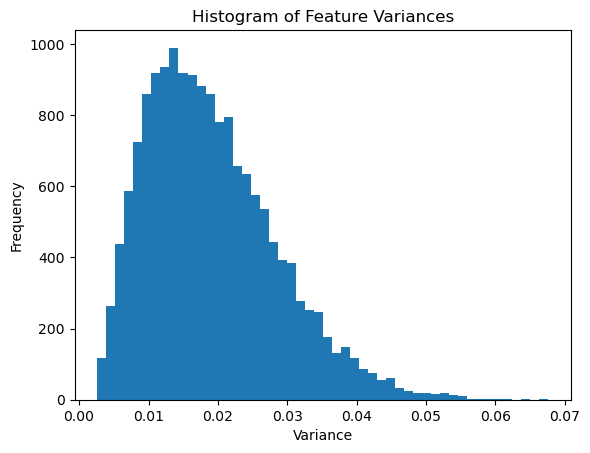

In [11]:
selector = VarianceThreshold().fit(MinMaxScaler().fit_transform(X))
variances = selector.variances_

plt.hist(variances, bins=50)
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Variances')
plt.show()

Default Feature Importance: Random forests provide a built-in way to evaluate feature importance, which is helpful for feature selection tasks.

In [12]:
thresholds = np.linspace(0, variances.max(), 50)
param_grid = {'variance_threshold__threshold': thresholds}
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('variance_threshold', VarianceThreshold()),
    ('classifier', RandomForestClassifier())
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_threshold = grid_search.best_params_['variance_threshold__threshold']
print("Best threshold based on cross-validation:", best_threshold)

Best threshold based on cross-validation: 0.0


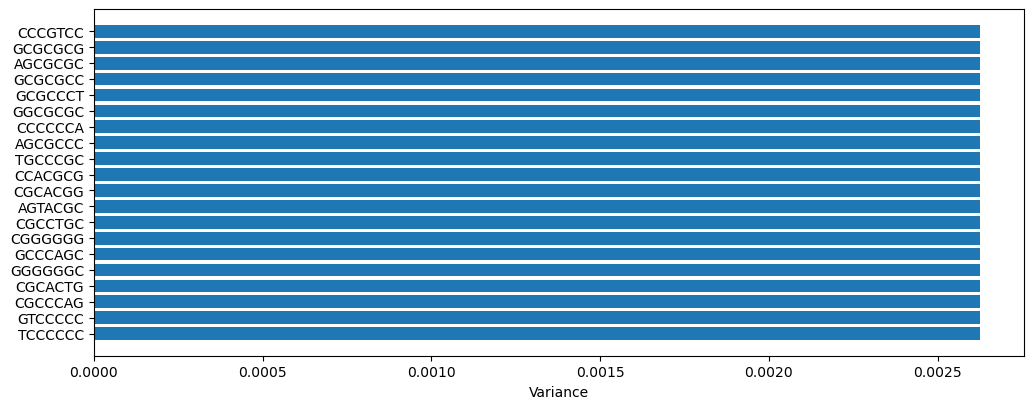

In [13]:
selector = VarianceThreshold(threshold=best_threshold).fit(MinMaxScaler().fit_transform(X))
variances = selector.variances_
var_sort = np.argsort(variances)

fig_scale = 3
feature_count = 20
plt.figure(figsize=(4*fig_scale, 1.5*fig_scale))
ypos = np.arange(feature_count)[::-1]
plt.barh(ypos, variances[var_sort][:feature_count], align='center')
plt.yticks(ypos, np.array(X.columns.values)[var_sort][:feature_count])
plt.xlabel("Variance");

In [14]:
selected_features = X.columns[selector.get_support()]
#print("Selected features based on initial quantile threshold:", selected_features.tolist())
print(f"Before selection= {len(X.columns.values)} / After = {len(selected_features)}")

Before selection= 16370 / After = 16370


In [15]:
best_score = grid_search.best_score_
print(best_score)

0.8657894736842104


**Note This methode is not revelant:** since the base line model with all feature give "acc:0.8842" and the optimized one give "acc:0.894" with just one feature reduction

* <span style="color: red">Covariance based feature selection (2)</span>

In [16]:
#@features_names = X.columns.values
#X_scaled = scale(X)
#cov = np.cov(X_scaled, rowvar=False)

#order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")
#features_names_ordered = [features_names[i] for i in order]

#fig_scale=5
#plt.figure(figsize=(3*fig_scale, 3*fig_scale))
#plt.imshow(cov[order, :][:, order], cmap='bwr')
#plt.xticks(range(X.shape[1]), features_names_ordered, ha="right")
#plt.yticks(range(X.shape[1]), features_names_ordered)
#plt.xticks(rotation=45)
#plt.colorbar(fraction=0.046, pad=0.04);

**Note**: It will be very difficult to select feature here. Also we should check whenever one between two features coreleate more with target. While correlation-based feature selection can be useful, it may not always be the best method for k-mer representations of DNA sequences due to the following reasons: k-mer features, especially for higher values of k, can result in very high-dimensional feature spaces, making correlation-based methods less effective; The relationships between k-mers and the target may be more complex and not adequately captured by simple linear correlations.

* <span style="color: red">Supervised feature selection (3)</span>

    * Model-based
    * Univariate feature selection is a type of feature selection technique used in machine learning to select the most relevant features from the original feature set. It operates by evaluating the relationship between each feature and the target variable independently, without considering the relationship between features.

In [17]:
# Utils to plot feature importance 

def plot_feature_importances(method1='f_test', method2=None, threshold=0.5):
    # Plot scores
    features_names = X.columns.values
    x = np.arange(len(X.columns.values))
    fig_scale = 4
    fig, ax1 = plt.subplots(1, 1, figsize=(4*fig_scale, 1*fig_scale))
    w = 0.3
    imp = fs[method1]
    mask = imp['select'][threshold]
    m1 = ax1.bar(x[mask], imp['scaled_score'][mask], width=w, color='b', align='center')
    ax1.bar(x[~mask], imp['scaled_score'][~mask], width=w, color='b', align='center', alpha=0.3)
    if method2:
        imp2 = fs[method2]
        mask2 = imp2['select'][threshold]
        ax2 = ax1.twinx()
        m2 = ax2.bar(x[mask2] + w, imp2['scaled_score'][mask2], width=w,color='g',align='center')
        ax2.bar(x[~mask2] + w, imp2['scaled_score'][~mask2], width=w,color='g',align='center', alpha=0.3)
        plt.legend([m1, m2],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold]),
                             '{} (Ridge R2:{:.2f})'.format(imp2['label'],imp2['cv_score'][threshold])], loc='upper left')
    else:
        plt.legend([m1],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold])], loc='upper left')
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names, rotation=45, ha="right");
    plt.title("Feature importance (selection threshold {:.2f})".format(threshold))        
    plt.show()

**Note**: We will use different techniques(supervised learning) to do feature selection then we use out utils "plot_feature_importances" to visualize and analyse. In this section, **we will pre-compute all importances on our dataset**.

In [70]:
from sklearn.feature_selection import f_classif, SelectPercentile, mutual_info_classif, SelectFromModel, RFE, SelectKBest, chi2
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from tqdm import tqdm

# Scaled feature selection thresholds
thresholds = [0.25, 0.5, 0.75, 1]

# Dict to store all data
fs = {}
methods = [
    'FTest','MutualInformation','RandomForest','Ridge','Lasso','RFE', 'ForwardSelection','FloatingForwardSelection', 'Permutation', 
    'knn'
]
for m in methods:
    fs[m] = {}
    fs[m]['select'] = {}
    fs[m]['cv_score'] = {}

def cv_score(selector):
    model = RandomForestClassifier()
    select_pipe = make_pipeline(StandardScaler(), selector, model)    
    return np.mean(cross_val_score(select_pipe, X, y, cv=5))

# We already tuned RF (pre-computed to save time)
randomforestCV = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)

In [19]:
# We define a 'template' model with full features and another one that will use selected features to see if feature selection 
# improves the model.

def assess_model_on_full_features(model):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("[ALL_FEATURE] -- Cross-validated accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_scores), np.std(cv_scores)))

def assess_model_on_selected_features(mask, model):
    mask_series = pd.Series(mask, index=X.columns)
    index_where_true = mask_series.index[mask_series.values]
    X_reduced = X[index_where_true] 
    cv_scores = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
    print("[SELECTED_FEATURE] -- Cross-validated accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_scores), np.std(cv_scores)))

* F-TEST
    * Consider each feature individually (univariate), independent of the model that you aim to apply
    * Use a statistical test: is there a linear statistically significant relationship with the target?
    * Use F-statistic (or corresponding p value) to rank all features, then select features using a threshold
    * Cannot detect correlations or interactions (e.g. binary features)
    * <span style="color: red;">F-TEST</span>

In [84]:
# F test
print("Computing F test")
fs['FTest']['label'] = "F test"
fs['FTest']['score'] = f_classif(scale(X),y)[0]
fs['FTest']['scaled_score'] = fs['FTest']['score'] / np.max(fs['FTest']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=f_classif, percentile=t*100).fit(scale(X), y)
    fs['FTest']['select'][t] = selector.get_support()
    fs['FTest']['cv_score'][t] = cv_score(selector)

Computing F test


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.59s/it]


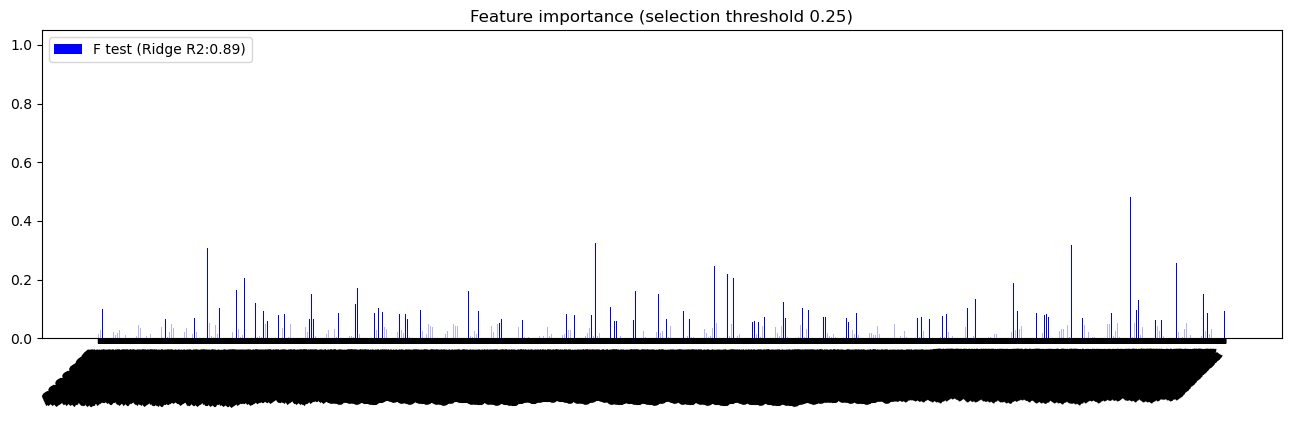

In [22]:
threshold=0.25
#plot_feature_importances('FTest', None, threshold=threshold)

In [85]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['FTest']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7421 ± 0.0197
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.9105 ± 0.0436


**Note**: For any value of threshold it does not improve prediction

* Model based feature selection
    * Use a tuned(!) supervised model to judge the importance of each feature
    * Linear models (Ridge, Lasso, LinearSVM,…): features with highest weights (coefficients)
    * Tree–based models: features used in first nodes (high information gain)
    * Captures interactions: features are more/less informative in combination
    * RandomForests: learns complex interactions (e.g. hour), but biased to high cardinality features
    * <span style="color: red">Random Forest</span>

In [89]:
# Random Forest
print("Computing Random Forest")
rf = randomforestCV
fs['RandomForest']['label'] = "Random Forest"
fs['RandomForest']['score'] = rf.fit(X, y).feature_importances_
fs['RandomForest']['scaled_score'] = fs['RandomForest']['score'] / np.max(fs['RandomForest']['score'])

for t in tqdm(thresholds):
    selector = SelectFromModel(rf, threshold="{}*mean".format((1-t)*2)).fit(X, y)
    fs['RandomForest']['select'][t] = selector.get_support()
    fs['RandomForest']['cv_score'][t] = cv_score(selector)

Computing Random Forest


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


In [30]:
threshold=0.25
plot_feature_importances('RandomForest', None, threshold=threshold)

In [90]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['RandomForest']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7632 ± 0.0432
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8132 ± 0.0652


* Model based feature selection
    * Use a tuned(!) supervised model to judge the importance of each feature
    * Linear models (Ridge, Lasso, LinearSVM,…): features with highest weights (coefficients)
    * Tree–based models: features used in first nodes (high information gain)
    * Captures interactions: features are more/less informative in combination
    * RandomForests: learns complex interactions (e.g. hour), but biased to high cardinality features
    * <span style="color: red">Ridge, Lasso</span>

In [93]:
# Ridge, Lasso
for m in [RidgeCV(),LassoCV()]:
    name = m.__class__.__name__.replace('CV','')
    print("Computing", name)
    fs[name]['label'] = name
    fs[name]['score'] = m.fit(X, y).coef_
    fs[name]['scaled_score'] = np.abs(fs[name]['score']) / np.max(np.abs(fs[name]['score'])) # Use absolute values
    for t in tqdm(thresholds):
        selector = SelectFromModel(m, threshold="{}*mean".format((1-t)*2)).fit(scale(X), y)
        fs[name]['select'][t] = selector.get_support()
        fs[name]['cv_score'][t] = cv_score(selector)

Computing Ridge


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.25s/it]


Computing Lasso


100%|█████████████████████████████████████████████████████████████████████████| 4/4 [17:29<00:00, 262.40s/it]


In [ ]:
threshold=0.25
plot_feature_importances('Ridge', 'Lasso', threshold=threshold)

In [94]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['Lasso']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7395 ± 0.0305
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.9842 ± 0.0098


In [95]:
# Mutual information
print("Computing Mutual information")
fs['MutualInformation']['label'] = "Mutual Information"
fs['MutualInformation']['score'] = mutual_info_classif(scale(X),y,discrete_features=range(13)) # first 13 features are discrete
fs['MutualInformation']['scaled_score'] = fs['MutualInformation']['score'] / np.max(fs['MutualInformation']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=mutual_info_classif, percentile=t*100).fit(scale(X), y)
    fs['MutualInformation']['select'][t] = selector.get_support()
    fs['MutualInformation']['cv_score'][t] = cv_score(selector)

Computing Mutual information


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [04:32<00:00, 68.17s/it]


In [38]:
threshold=0.5
#plot_feature_importances('MutualInformation', None, threshold=threshold)

In [39]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['MutualInformation']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7395 ± 0.0579
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.7947 ± 0.0475


* Iterative Model-based Feature Selection
    * Dropping many features at once is not ideal: feature importance may change in subset
    * Recursive Feature Elimination (RFE)
        *Remove least important feature(s), recompute remaining importances, repeat
    * Can be rather slow
    * <span style="color: red">RFE</span>

In [ ]:
# Recursive Feature Elimination
print("Computing RFE")
fs['RFE']['label'] = "Recursive Feature Elimination (with RandomForest)"
fs['RFE']['score'] = RFE(RandomForestClassifier(), n_features_to_select=1).fit(X, y).ranking_
fs['RFE']['scaled_score'] = (20 - fs['RFE']['score'])/ 19
for t in tqdm(thresholds):
    selector = RFE(RandomForestClassifier(), n_features_to_select=int(t*20)).fit(X, y)
    fs['RFE']['select'][t] = selector.support_
    fs['RFE']['cv_score'][t] = cv_score(selector)

In [ ]:
threshold=0.5
plot_feature_importances('RFE', 'RandomForest', threshold=threshold)

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['RFE']['select'][threshold], model)

* Permutation feature importance
    * Defined as the decrease in model performance when a single feature value is randomly shuffled
        * This breaks the relationship between the feature and the target
    * Model agnostic, metric agnostic, and can be calculated many times with different permutations
    * Can be applied to unseen data (not possible with model-based techniques)
    * Less biased towards high-cardinality features (compared with RandomForests)
    * <span style="color: red">Permutation & RandomForest</span>

In [41]:
# Permutation Importance  
print("Computing Permutation importance")
fs['Permutation']['label'] = "Permutation importance (with RandomForest))"
fs['Permutation']['score'] = permutation_importance(RandomForestClassifier().fit(X, y), X, y,  n_repeats=10, random_state=42, 
                                                    n_jobs=-1).importances_mean
fs['Permutation']['scaled_score'] = fs['Permutation']['score'] / np.max(fs['Permutation']['score'])
sorted_idx = (-fs['Permutation']['score']).argsort()
num_feature = len(X.columns.values)
for t in tqdm(thresholds):
    mask = np.array([x in sorted_idx[:int(t*num_feature)] for x in range(num_feature)])
    fs['Permutation']['select'][t] = mask
    # Hard to use this in a pipeline, resorting to transforming the data beforehand

    mask_series = pd.Series(mask, index=X.columns)
    selected_index = mask_series.index[mask_series.values]
    fs['Permutation']['cv_score'][t] = np.mean(cross_val_score(RandomForestClassifier(), X[selected_index], y, cv=3))

Computing Permutation importance


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


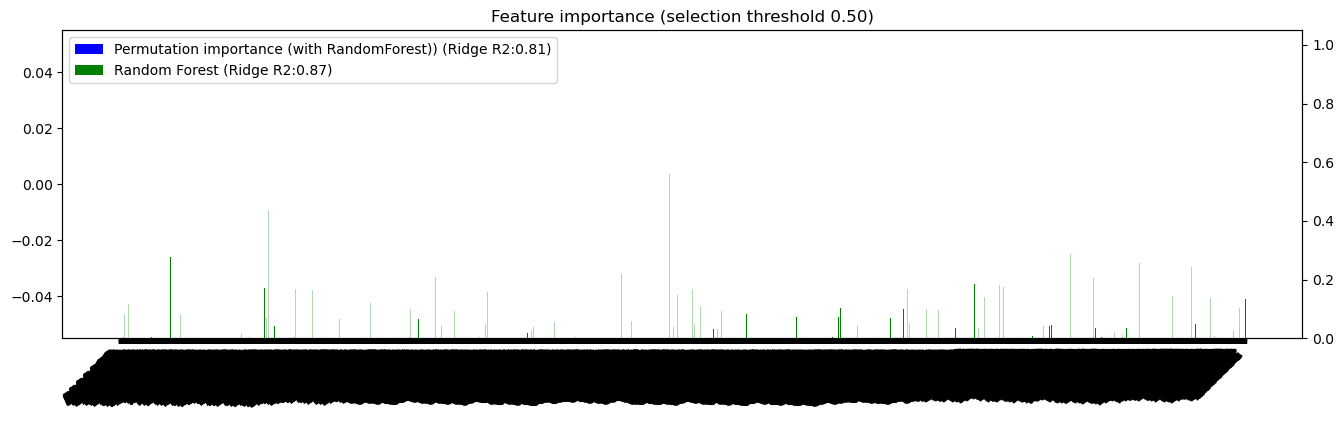

In [42]:
threshold=0.5
plot_feature_importances('Permutation', 'RandomForest', threshold=threshold)

In [43]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['Permutation']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7553 ± 0.0271
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.7684 ± 0.0396


* <span style="color: red">New Feature selection for k-mer (Motif Independent Measure (MIM))</span>
    * We can realize that the previous technique is not always accurate and requires training on a lot of data, which is time-consuming.
    * https://www.researchgate.net/publication/268977663_A_new_feature_selection_strategy_for_K-mers_sequence_representation

Let's get a look of our Feature space

In [44]:
X.head()

,AAAAAAA,AAAAAAC,AAAAAAG,AAAAAAT,AAAAACA,AAAAACC,AAAAACG,AAAAACT,AAAAAGA,AAAAAGC,...,TTTTTCG,TTTTTCT,TTTTTGA,TTTTTGC,TTTTTGG,TTTTTGT,TTTTTTA,TTTTTTC,TTTTTTG,TTTTTTT
0,0.001309,0.000000,0.000436,0.000436,0.000000,0.000000,0.0,0.000000,0.000436,0.000000,...,0.000000,0.000873,0.000436,0.000000,0.000873,0.000436,0.000436,0.000436,0.000436,0.000436
1,0.003408,0.000000,0.000000,0.002045,0.000000,0.000000,0.0,0.000000,0.000682,0.000000,...,0.000000,0.001363,0.000000,0.000682,0.000682,0.000682,0.000682,0.000682,0.002045,0.001363
2,0.000000,0.000000,0.000000,0.000339,0.000339,0.000000,0.0,0.000000,0.000000,0.000339,...,0.000000,0.001016,0.000339,0.000000,0.000000,0.001694,0.000678,0.000000,0.000339,0.001016
3,0.003183,0.000455,0.000910,0.000455,0.000455,0.000455,0.0,0.000455,0.000455,0.000000,...,0.000455,0.000910,0.000000,0.000000,0.000455,0.000000,0.000910,0.001364,0.000000,0.001819
4,0.000000,0.000000,0.000502,0.000502,0.001004,0.000000,0.0,0.000502,0.000000,0.001004,...,0.000000,0.001004,0.000000,0.000000,0.000000,0.000502,0.001506,0.001004,0.000502,0.003012


**Paper**: The idea behind the proposed feature selection method is to assign a weight to each k-mer, and use this weights for their selection.

In [96]:
# let P be the k-mer probability distributions corresponding to a set of n target sequences S = {si}
P = X.to_numpy()
# Let Q be the k-mer probability distributions corresponding to B for a fixed length k.
Q = None

Symmetrical Kullback-Leibler divergence between the empirical probabilities Pj and Qj

In [97]:
def kullback_leibler_divergence(P, Q):
    J = P.shape[1]
    dkl = np.zeros(J)
    epsilon = 1e-10
    for j in range(J):
        P_j = P[:, j]
        Q_j = Q[:, j]
        P_j = np.where(P_j == 0, epsilon, P_j)
        Q_j = np.where(Q_j == 0, epsilon, Q_j)
        dkl[j] = 0.5 * (np.sum(P_j * np.log(P_j / Q_j)) + np.sum(Q_j * np.log(Q_j / P_j)))
    return dkl

The Motif Independent Measure (MIM) value corresponding to ak-mer wj is defined as the expected value dkl(Pj , Qj ), which is estimated by averagingover a finite set N > n of background sequences, and is indicated as MIM(wj ). 

In [98]:
def MIM_Feature_Selector(P, Q, alpha, beta):
    assert alpha < 1 and beta < 1, "Error: alpha and beta should be lower than 1"
    m = P.shape[1]
    mim_values = kullback_leibler_divergence(P, Q)
    z_scores = zscore(mim_values)
    
    # Identify k-mers with Z-scores above the threshold
    A_alpha_pos = np.where(np.abs(z_scores) > alpha)[0]
    A_alpha = mim_values[A_alpha_pos]
    
    # Select the number of k-mers based on the criteria
    r = max(np.linalg.norm(A_alpha, ord=1), int(beta * m))
    selected_kmers_indices = np.argsort(mim_values)[:r]

    # Generate mask
    selection_mask = np.zeros(m, dtype=bool)
    selection_mask[selected_kmers_indices] = True
    
    return selection_mask

* Test

In [99]:
# USING FULL FEATURE AS BACKGROUND SEQUENCE

alpha = 0.7
beta = 0.5
feature_mask_1 = MIM_Feature_Selector(P, P, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_1)}")

Feature before: 16370 - Feature After: 8185


In [100]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16) 
assess_model_on_full_features(model) 
assess_model_on_selected_features(feature_mask_1, model) 

[ALL_FEATURE] -- Cross-validated accuracy: 0.7553 ± 0.0359
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.7553 ± 0.0271


In [101]:
# USING NEGATIVE BACKGROUND AS BACKGROUND SEQUENCE
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i][::-1], k=k, step=1))
    
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_inv = pd.DataFrame(feature_values, columns=feature_names)
Q = X_inv.to_numpy()

alpha = 0.7
beta = 0.5
feature_mask_2 = MIM_Feature_Selector(P, Q, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_2)}")

Feature before: 16370 - Feature After: 8185


In [102]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(feature_mask_2, model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7342 ± 0.0548
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.7553 ± 0.0421


In [103]:
# USING RANDOM BACKGROUND SELECTION

from itertools import product
def calculate_nucleotide_probabilities(sequences, k):
    kmers_count = []
    for seq in sequences:
        nucleotide_counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
        total_nucleotides = 0
        kmers = {}
        
        for nucleotide in seq:
            if nucleotide in nucleotide_counts:
                nucleotide_counts[nucleotide] += 1
                total_nucleotides += 1
    
        probabilities = {nucleotide: count / total_nucleotides for nucleotide, count in nucleotide_counts.items()}
        nucleotides = list(probabilities.keys())
    
        for kmer in product(nucleotides, repeat=k):
            kmer_prob = np.prod([probabilities[n] for n in kmer])
            kmers[''.join(kmer)] = kmer_prob
        
        kmers_count.append(kmers)
    return kmers_count
        
kmers_count = calculate_nucleotide_probabilities(sequences, k)

v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_inv = pd.DataFrame(feature_values, columns=feature_names)
Q = X_inv.to_numpy()

alpha = 0.7
beta = 0.5
feature_mask_3 = MIM_Feature_Selector(P, Q, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_2)}")

Feature before: 16370 - Feature After: 8185


In [104]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(feature_mask_3, model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7263 ± 0.0614
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.7789 ± 0.0419


<h4 style="background-color: #3ab76f; border-top: 4px solid #dddddd; display: flex; color: white;">
    <ul><li>RESULT</li></ul>
</h4>

* Utils

In [125]:
def prepare_dataset(k):
    sequences   = dataset['sequence']
    kmers_count = []
    for i in range(len(sequences)):
        kmers_count.append(kmer_count(sequences[i], k=k, step=1))
    v = DictVectorizer(sparse=False)
    feature_values = v.fit_transform(kmers_count)
    feature_names = v.get_feature_names_out()
    X = pd.DataFrame(feature_values, columns=feature_names)
    y = dataset['class']
    return X,y

def tune_model(model_conf, X, y):
    best_models = []
    for config in model_conf:
        name = config['name']
        model = config['model']
        params = config['params']
        
        print(f"Tuning {name}")
        if params:
            grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"Best params for {name}: {best_params}")
        else:
            best_model = model
            print(f"No hyperparameters to tune for {name}")
    
        best_models.append({
            'name': name,
            'model': best_model,
        })
    return best_models
    
def trace_model_performance(traced_performance, tuned_models, feature_mask, feature_selection_method, X, y, k_mer_size, out=""):
    for model_info in tuned_models:
        name = model_info['name']
        model = model_info['model']
        
        # Apply the feature mask if provided
        feature_name = "-".join(X.columns.values)
        if feature_mask is not None:
            mask_series = pd.Series(feature_mask, index=X.columns)
            selected_features = mask_series[mask_series].index
            X_reducted = X[selected_features]
            feature_name = "-".join(selected_features)
        else:
            X_reducted = X

        print(f"Evaluating {name} with feature selection method: {feature_selection_method}")

        # Perform cross-validation
        cv_results = cross_validate(model, X_reducted, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
        best_score = np.mean(cv_results['test_accuracy'])
        std_score = np.std(cv_results['test_accuracy'])
        precision = np.mean(cv_results['test_precision'])
        recall = np.mean(cv_results['test_recall'])
        f1 = np.mean(cv_results['test_f1'])

        traced_performance.append({
            'name': name,
            'model': model,
            'score': best_score,
            'std_score': std_score,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'feature_selection_method': feature_selection_method,
            'k-mer': k_mer_size,
            'feature': feature_name
        })

        # SAVE RESULT
        df_performance = pd.DataFrame(traced_performance)
        df_performance.to_csv(out, index=False)

* Model

In [ ]:
model_conf = [
    {'name':'GaussianProcessClassifier', 'model':GaussianProcessClassifier(), "params": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]}},
    {'name':'RandomForestClassifier', 'model':RandomForestClassifier(), "params": {'max_depth': [8, 16, 32, 64, 128], 'n_estimators': [10, 50, 100, 200, 300], 'max_features': [2, 4, 8, 16]}},
    {'name':'AdaBoostClassifier', 'model':AdaBoostClassifier(), "params": {'n_estimators': [50, 100, 200]}},
    {'name':'GaussianNB', 'model':GaussianNB(), "params": None},
]

* k=7

In [126]:
X, y = prepare_dataset(7)
traced_performance = []
threshold = 0.25
path_result=f'./Output/FSelect/result_k_{k}.csv'

In [ ]:
tuned_models = tune_model(model_conf, X, y)

In [128]:
tuned_models

[{'name': 'GaussianProcessClassifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))},
 {'name': 'RandomForestClassifier',
  'model': RandomForestClassifier(max_depth=128, max_features=16, n_estimators=300)},
 {'name': 'AdaBoostClassifier', 'model': AdaBoostClassifier(n_estimators=200)},
 {'name': 'GaussianNB', 'model': GaussianNB()}]

In [129]:
trace_model_performance(traced_performance, tuned_models, None, "No", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: No
Evaluating RandomForestClassifier with feature selection method: No
Evaluating AdaBoostClassifier with feature selection method: No
Evaluating GaussianNB with feature selection method: No


In [130]:
trace_model_performance(traced_performance, tuned_models, None, "Variance-based(1)", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: Variance-based(1)
Evaluating RandomForestClassifier with feature selection method: Variance-based(1)
Evaluating AdaBoostClassifier with feature selection method: Variance-based(1)
Evaluating GaussianNB with feature selection method: Variance-based(1)


In [131]:
trace_model_performance(traced_performance, tuned_models, fs['FTest']['select'][threshold], "FTest", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: FTest
Evaluating RandomForestClassifier with feature selection method: FTest
Evaluating AdaBoostClassifier with feature selection method: FTest
Evaluating GaussianNB with feature selection method: FTest


In [132]:
trace_model_performance(traced_performance, tuned_models, fs['RandomForest']['select'][threshold], "RandomForest", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: RandomForest
Evaluating RandomForestClassifier with feature selection method: RandomForest
Evaluating AdaBoostClassifier with feature selection method: RandomForest
Evaluating GaussianNB with feature selection method: RandomForest


In [133]:
trace_model_performance(traced_performance, tuned_models, fs['Lasso']['select'][threshold], "Lasso", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: Lasso
Evaluating RandomForestClassifier with feature selection method: Lasso
Evaluating AdaBoostClassifier with feature selection method: Lasso
Evaluating GaussianNB with feature selection method: Lasso


In [134]:
trace_model_performance(traced_performance, tuned_models, fs['MutualInformation']['select'][threshold], "MutualInformation", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MutualInformation
Evaluating RandomForestClassifier with feature selection method: MutualInformation
Evaluating AdaBoostClassifier with feature selection method: MutualInformation
Evaluating GaussianNB with feature selection method: MutualInformation


In [135]:
trace_model_performance(traced_performance, tuned_models, feature_mask_1, "MIM-FULL", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-FULL
Evaluating RandomForestClassifier with feature selection method: MIM-FULL
Evaluating AdaBoostClassifier with feature selection method: MIM-FULL
Evaluating GaussianNB with feature selection method: MIM-FULL


In [136]:
trace_model_performance(traced_performance, tuned_models, feature_mask_2, "MIM-NB", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-NB
Evaluating RandomForestClassifier with feature selection method: MIM-NB
Evaluating AdaBoostClassifier with feature selection method: MIM-NB
Evaluating GaussianNB with feature selection method: MIM-NB


In [137]:
trace_model_performance(traced_performance, tuned_models, feature_mask_3, "MIM-RB", X, y, 7, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-RB
Evaluating RandomForestClassifier with feature selection method: MIM-RB
Evaluating AdaBoostClassifier with feature selection method: MIM-RB
Evaluating GaussianNB with feature selection method: MIM-RB


In [138]:
# VIEW RESULT
df_performance = pd.read_csv(path_result)
df_performance

,name,model,score,std_score,precision,recall,f1,feature_selection_method,k-mer,feature
0,GaussianProcessClassifier,GaussianProcessClassifier(kernel=1**2 * RBF(le...,0.902632,0.024404,0.905776,0.931290,0.916411,No,7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
1,RandomForestClassifier,"RandomForestClassifier(max_depth=128, max_feat...",0.786842,0.057294,0.751414,0.945243,0.835257,No,7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
2,AdaBoostClassifier,AdaBoostClassifier(n_estimators=200),0.868421,0.047075,0.925204,0.839323,0.878877,No,7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
3,GaussianNB,GaussianNB(),0.636842,0.029539,0.613417,0.995455,0.758949,No,7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
4,GaussianProcessClassifier,GaussianProcessClassifier(kernel=1**2 * RBF(le...,0.902632,0.024404,0.905776,0.931290,0.916411,Variance-based(1),7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
5,RandomForestClassifier,"RandomForestClassifier(max_depth=128, max_feat...",0.755263,0.029539,0.720604,0.940698,0.814946,Variance-based(1),7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
6,AdaBoostClassifier,AdaBoostClassifier(n_estimators=200),0.868421,0.047075,0.925204,0.839323,0.878877,Variance-based(1),7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
7,GaussianNB,GaussianNB(),0.636842,0.029539,0.613417,0.995455,0.758949,Variance-based(1),7,AAAAAAA-AAAAAAC-AAAAAAG-AAAAAAT-AAAAACA-AAAAAC...
8,GaussianProcessClassifier,GaussianProcessClassifier(kernel=1**2 * RBF(le...,0.968421,0.019693,0.976840,0.967865,0.972250,FTest,7,AAAAAGA-AAAACAT-AAAAGCT-AAAAGGC-AAAATCA-AAAATC...
9,RandomForestClassifier,"RandomForestClassifier(max_depth=128, max_feat...",0.921053,0.036274,0.920307,0.945137,0.932046,FTest,7,AAAAAGA-AAAACAT-AAAAGCT-AAAAGGC-AAAATCA-AAAATC...


In [ ]:
fs